# **PCA implementation**
The following implementation is based on the circuit shown in the image below
<div>
<img src="img/pca_circuit.png" width="700">
</div>

# **Import of basic libraries**

In [64]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, BasicAer, execute
from qiskit.extensions import UnitaryGate

import matplotlib.pyplot as plt
import numpy as np
import math

from utils.utils import dprint, print_matrix, set_debug
set_debug(True) # Set to True to print debug information during execution

# **Data used for testing**
### **Dataset 1**
Number of bedrooms ($x_1$) and the square footage ($x_2$) of several houses (15) for sale in Los Alamos.<br>

For scaling purposes, the square footage were divided by 1000 and the respective averages were subtracted from both features.

With respect to the features described, the expected covariance matrix $\Sigma$ and its eigenvalues $e_1$ and $e_2$ are:
$$\Sigma=\begin{pmatrix}
        0.380952 & 0.573476\\
        0.573476 & 1.29693
        \end{pmatrix},\quad e_1=1.57286,\quad e_2=0.105029$$

### **Dataset 2**
Dataset taken from [kaggle](https://www.kaggle.com/datasets/youssefaboelwafa/clustering-penguins-species?resource=download). Originally composed of 5 features but only the first two were extracted: culmen length ($x_1$) and culmen depth ($x_2$).<br>

With respect to the features described, the expected covariance matrix $\Sigma$ and its eigenvalues $e_1$ and $e_2$ are:
$$\Sigma=\begin{pmatrix}
        29.807054 & -2.534234\\
        -2.534234 & 3.899808
        \end{pmatrix},\quad e_1=30.05262,\quad e_2=3.65424$$

In [65]:
DATASET = 0 # 0: Los Alamos housing prices dataset, 1: Penguin dataset

match DATASET:
    case 0:
        x1 = np.array([4,3,4,4,3,3,3,3,4,4,4,5,4,3,4])
        x2 = np.array([3028,1365,2726,2538,1318,1693,1412,1632,2875,3564,4412,4444,4278,3064,3857])
        x2 = x2 / 1000
    case 1:
        with open('dataset/penguins.txt', 'r', encoding='utf-8-sig') as file:
            lines = file.readlines()
            x1 = np.array([float(value) for value in lines[0].split(",")])
            x2 = np.array([float(value) for value in lines[1].split(",")])
    case _:
        raise ValueError("Invalid dataset")

x1 = x1 - np.mean(x1)
x2 = x2 - np.mean(x2)

# **Building blocks definition**

## **Classical precomputation**
1. Convert raw data vectors into covariance matrix $\Sigma$
2. Normalize matrix to form $\rho = \frac{\Sigma}{Tr(\Sigma)}$
3. Purify $\rho$ to make a pure state $\ket{\psi}$
4. Compute and return the unitary $U_{prep}$ needed to prepare $\ket{\psi}$ from a pair of qubits each initially in the $\ket{0}$ state

In [66]:
def classical_precomputation(x1: np.array, x2: np.array) -> tuple[UnitaryGate, np.array]:
    """
    1. Convert raw data vectors into covariance matrix sigma
    2. Normalize matrix to form rho = sigma/Tr(sigma)
    3. Purify rho to make a pure state |psi>
    4. Compute and return the unitary Uprep needed to prepare |psi>
        from a pair of qubits each initially in the |0> state

    Args:
        x1 (np.array): vector of data points for x1
        x2 (np.array): vector of data points for x2

    Returns:
        UnitaryGate: the unitary Uprep needed to prepare |psi>
        np.array: the covariance matrix sigma
    """
    # 1. Covariance matrix sigma
    sigma = np.cov(x1, x2)
    dprint('Covariance matrix Σ:')
    print_matrix(sigma, ndigits=5)

    # 2. Normalize matrix
    rho = sigma / np.trace(sigma)
    dprint('Normalized matrix ρ:')
    print_matrix(rho, ndigits=5)

    # 3. Purify rho
    eigenvalues, eigenvectors = np.linalg.eig(rho)
    e1 = math.sqrt(eigenvalues[0])
    e2 = math.sqrt(eigenvalues[1])
    v1 = eigenvectors[0,:]
    v2 = eigenvectors[1,:]
    psi_0 = np.array([e1 * v1[0], e1 * v1[1], e2 * v2[0], e2 * v2[1]])
    dprint(f'Purified state |ψ> = {psi_0}')

    # 4. Compute unitary Uprep
    v_1 = np.array([0, 1, 0, 0], dtype=np.float64)
    v_2 = np.array([0, 0, 1, 0], dtype=np.float64)
    v_3 = np.array([0, 0, 0, 1], dtype=np.float64)

    ## Gram-Schmidt orthogonalization
    basis_vectors = [psi_0, v_1, v_2, v_3]
    ortho_basis = []
    for v in basis_vectors:
        for u in ortho_basis:
            v -= np.dot(u, v) * u
        v = v / np.linalg.norm(v)
        ortho_basis.append(v)

    dprint(f'Normalized purified state |ψ> = {ortho_basis[0]}')

    ## Form the unitary matrix U
    u = np.column_stack(ortho_basis)
    return UnitaryGate(u, label='Uprep'), sigma

## **State preparation**
Prepare two copies of the state $\ket{\psi}$ using the predefined $U_{prep}$

In [67]:
def state_preparation(circuit: QuantumCircuit, U: UnitaryGate):
    """
    Add the unitary U to the circuit to prepare the state |psi> from a initial pair of qubits in the |00> state

    Args:
        circuit (QuantumCircuit): the circuit to add the unitary to
        U (UnitaryGate): the unitary U to apply
    """
    circuit.append(U, [1, 2])
    circuit.append(U, [3, 4])
    circuit.barrier()

## **Purity calculation**

In [68]:
def purity_calculation(circuit: QuantumCircuit):
    """
    Add the circuit to calculate the purity of the state |psi> in the circuit

    Args:
        circuit (QuantumCircuit): the circuit to add the purity calculation to
    """
    circuit.h(0)
    circuit.cswap(0, 1, 3)
    circuit.h(0)
    circuit.barrier()

## **Classical post processing**
Classically compute the eigenvalues ​​from the purity value ($P$) calculated in the previous step using the following equations:
$$e_1 = Tr(\Sigma) *\frac{1 + \sqrt{1 - 2(1-P)}}{2}, \quad e_2 = Tr(\Sigma) *\frac{1 - \sqrt{1 - 2(1-P)}}{2}$$

In [69]:
def classical_post_processing(P: float, sigma: np.array) -> tuple[float, float]:
    """
    Compute the eigenvalues of the density matrix sigma

    Args:
        P (float): purity of the density matrix
        sigma (np.array): the covariance matrix

    Returns:
        tuple[float, float]: the eigenvalues of the density matrix
    """
    e1 = np.trace(sigma) * (1 + math.sqrt(1 - 2 * (1 - P))) / 2
    e2 = np.trace(sigma) * (1 - math.sqrt(1 - 2 * (1 - P))) / 2
    return e1, e2

# **Circuit definition**

Covariance matrix Σ:
0.38095, 0.57348
0.57348, 1.29693
Normalized matrix ρ:
0.22704, 0.34178
0.34178, 0.77296
Purified state |ψ> = [-0.22545283 -0.10847494  0.41977861 -0.8724621 ]
Normalized purified state |ψ> = [-0.22545283 -0.10847494  0.41977861 -0.8724621 ]


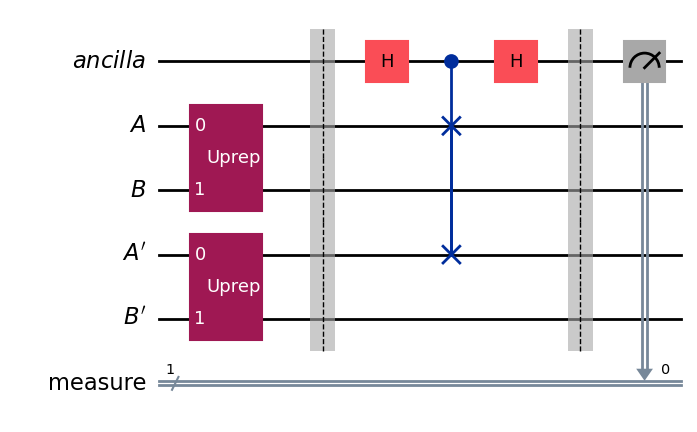

In [70]:
# Create the circuit
ancilla = QuantumRegister(1, name='ancilla')
A = QuantumRegister(1, name='A')
B = QuantumRegister(1, name='B')
A1 = QuantumRegister(1, name='A\'')
B1 = QuantumRegister(1, name='B\'')
measure = ClassicalRegister(1, name='measure')

circuit = QuantumCircuit(ancilla, A, B, A1, B1, measure)

# Classical precomputation
U, sigma = classical_precomputation(x1, x2)

# State preparation
state_preparation(circuit, U)

# Purity calculation
purity_calculation(circuit)

# Add measurement
circuit.measure(ancilla, measure)

circuit.draw(output='mpl', style="iqp")

# **Circuit execution**

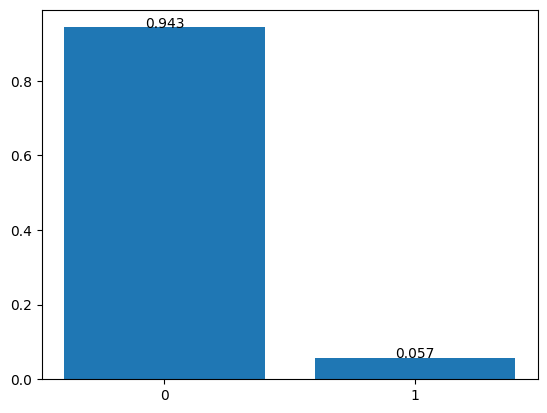

In [71]:
# Execute the circuit using the simulator
shots = 40000
simulator = BasicAer.get_backend('qasm_simulator')
job = execute(circuit, backend=simulator, shots=shots)

#Get the result of the execution
result = job.result()

# Get the counts, the frequency of each answer
counts = result.get_counts(circuit)

# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], round(y[i], 3), ha = 'center')

# Display the results
values = np.array(list(counts.values())) / shots
plt.bar(counts.keys(), values)
addlabels(counts.keys(), values)
plt.show()

# **Results**

In [72]:
p0 = counts['0']
p1 = counts['1']
P = (p0 - p1) / shots

# Classical post-processing
e1, e2 = classical_post_processing(P, sigma)

print(f'Resulting purity: {P}')
print(f"Resulting eigenvalues of the density matrix -> e1: {round(e1, 5)}, e2: {round(e2, 5)}\n")

# Expected result
rho = sigma / np.trace(sigma)
P = np.trace(np.linalg.matrix_power(rho, 2))
e1, e2 = classical_post_processing(P, sigma)
print(f'Expected purity: {round(P, 5)}')
print(f"Expected eigenvalues of the density matrix -> e1: {round(e1, 5)}, e2: {round(e2, 5)}")

Resulting purity: 0.88635
Resulting eigenvalues of the density matrix -> e1: 1.5764, e2: 0.10148

Expected purity: 0.88264
Expected eigenvalues of the density matrix -> e1: 1.57286, e2: 0.10503
